## Gene Ontology Analysis

This notebook reproduces Fig. 2

Authors: Anna Ida Trolle and Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter
import scipy as sc
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
import pickle
from matplotlib.patches import Patch
from scipy import stats
import statsmodels.stats.multitest
from functools import partial
from localcider.sequenceParameters import SequenceParameters
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
import obonet
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

def error_prop_ratio(v1,v2,e1,e2):
    ratio = v1/v2
    return ratio*np.sqrt((e1/v1)**2+(e2/v2)**2)  

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def map_to_curated_codes(graph, GO_terms, curated_GO_codes, nodes):
    new_codes = np.empty(0)
    for code in GO_terms:
        if code in nodes and code != 'unknown':
            ancestors = list(nx.dfs_predecessors(graph, source=code, depth_limit=None).values())
            ancestors += list(nx.dfs_predecessors(graph, source=code, depth_limit=None).keys())
            intersect = np.intersect1d(ancestors, curated_GO_codes)
            if intersect.size==0:
                intersect = np.append(intersect, 'other')
            new_codes = np.append(new_codes, intersect)
    return np.unique(new_codes).tolist()

def calc_ORs(df_GO,GO_terms,intervals,curated_GO_terms):
    #aggregate data based on bins
    df_binned = df_GO.groupby(intervals).agg({'UniProt_ID':np.sum})
    df_binned['GO'] = df_binned.UniProt_ID.apply(lambda x : GO_terms.loc[x].GO.sum())
    df_binned['count_IDs'] = df_binned.UniProt_ID.apply(len)
    df_binned['count_GO'] = df_binned.GO.apply(len)
    
    for GO in curated_GO_terms:
        code = name_to_id[GO]
        df_binned[GO] = df_binned.GO.apply(lambda x : x.count(code))
    df_binned['other'] = df_binned.GO.apply(lambda x : x.count('other'))

    df_stat = pd.DataFrame(index=curated_GO_terms+['other'], 
                             columns = ['OR','p_value','OR_errlow','OR_errhigh','asymmetric_err'])
    for name in curated_GO_terms+['other']:
        table = df_binned[[name, 'count_IDs']] 
        table.iloc[0]['count_IDs'] -= table.iloc[0][name]
        table.iloc[1]['count_IDs'] -= table.iloc[1][name]
        res = fisher_exact(table.values, alternative='two-sided')
        df_stat.loc[name,'p_value'] = res.pvalue
        res = odds_ratio(table.values,kind='conditional')
        or_value = res.statistic
        df_stat.loc[name,'OR'] = or_value
        or_err = res.confidence_interval(confidence_level=0.95)
        df_stat.loc[name,'OR_errlow'] = or_err.low
        df_stat.loc[name,'OR_errhigh'] = or_err.high

    for name in curated_GO_terms+['other']:
        df_stat.at[name,'asymmetric_err'] = ([df_stat.loc[name, 'OR']-(df_stat.loc[name, 'OR_errlow']),
                                                (df_stat.loc[name, 'OR_errhigh']-df_stat.loc[name, 'OR'])])

    BenjaminiHochberg, correctedP = statsmodels.stats.multitest.fdrcorrection(df_stat['p_value'].values, 
                                                            alpha=0.05, method='indep', is_sorted=False)
    df_stat['BenjaminiHochberg'] = BenjaminiHochberg
    df_stat['correctedP'] = correctedP
    return df_stat

def calc_ORs_Expanded(df_GO,GO_terms,intervals,curated_GO_terms):
    #aggregate data based on bins
    df_binned = df_GO.groupby(intervals).agg({'UniProt_ID':np.sum})
    df_binned['GO'] = df_binned.UniProt_ID.apply(lambda x : GO_terms.loc[x].GO.sum())
    df_binned['count_IDs'] = df_binned.UniProt_ID.apply(len)
    df_binned['count_GO'] = df_binned.GO.apply(len)
    
    for GO in curated_GO_terms:
        code = name_to_id[GO]
        df_binned[GO] = df_binned.GO.apply(lambda x : x.count(code))
    df_binned['other'] = df_binned.GO.apply(lambda x : x.count('other'))

    df_stat = pd.DataFrame(index=curated_GO_terms+['other'], 
                             columns = ['OR','p_value','OR_errlow','OR_errhigh','asymmetric_err'])
    for name in curated_GO_terms+['other']:
        table = df_binned[[name, 'count_IDs']]
        table.iloc[0]['count_IDs'] -= table.iloc[0][name]
        table.iloc[1]['count_IDs'] -= table.iloc[1][name]
        table = table.iloc[::-1] 
        res = fisher_exact(table.values, alternative='two-sided')
        df_stat.loc[name,'p_value'] = res.pvalue
        res = odds_ratio(table.values,kind='conditional')
        or_value = res.statistic
        df_stat.loc[name,'OR'] = or_value
        or_err = res.confidence_interval(confidence_level=0.95)
        df_stat.loc[name,'OR_errlow'] = or_err.low
        df_stat.loc[name,'OR_errhigh'] = or_err.high

    for name in curated_GO_terms+['other']:
        df_stat.at[name,'asymmetric_err'] = ([df_stat.loc[name, 'OR']-(df_stat.loc[name, 'OR_errlow']),
                                                (df_stat.loc[name, 'OR_errhigh']-df_stat.loc[name, 'OR'])])

    BenjaminiHochberg, correctedP = statsmodels.stats.multitest.fdrcorrection(df_stat['p_value'].values, 
                                                            alpha=0.05, method='indep', is_sorted=False)
    df_stat['BenjaminiHochberg'] = BenjaminiHochberg
    df_stat['correctedP'] = correctedP
    return df_stat

#### Load basic version of the GO

In [2]:
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'
graph = obonet.read_obo(url)

id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

#### Get nodes connected to molecular function, biological process, and cellular component

In [3]:
print(name_to_id['molecular_function'],name_to_id['biological_process'],name_to_id['cellular_component'])
molfunc = list(nx.ancestors(graph, 'GO:0003674')) # all nodes connected to molecular function
bioproc = list(nx.ancestors(graph, 'GO:0008150')) # all nodes connected to biological process
cellcom = list(nx.ancestors(graph, 'GO:0005575')) # all nodes connected to cellular component

GO:0003674 GO:0008150 GO:0005575


#### $\nu$ values to identify IDRs in the most compact and most expanded 5%

In [51]:
lower_cutoff = 0.477
upper_cutoff = 0.581

#### Searching for TFs analysed by Staller et al. (DOI: https://doi.org/10.1016/j.cels.2022.01.002)

In [103]:
dataset_3 = pd.read_csv('https://ars.els-cdn.com/content/image/1-s2.0-S2405471222000023-mmc4.csv',
           storage_options={'User-Agent': 'Mozilla/5.0'},index_col=2)

df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)

tfs_staller = []

df_staller = df_idrome[df_idrome.UniProt_ID.isin(dataset_3.index)].query(f'nu <= {lower_cutoff:g}')
for idr in df_staller.index:
    if type(dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq) == str:
        if dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq in df_staller.loc[idr].fasta:
            print(df_staller.loc[idr].protein_name)
            tfs_staller.append(idr)
    else:
        for seq in dataset_3.loc[df_staller.loc[idr].UniProt_ID].ProteinRegionSeq.values:
            if seq in df_staller.loc[idr].fasta:
                print(df_staller.loc[idr].protein_name)
                tfs_staller.append(idr)
print(len(tfs_staller))

Forkhead box protein O6
Forkhead box protein O3
Transcription factor SOX-11
Forkhead box protein O4
Zinc finger protein Rlf
Zinc finger protein interacting with ribonucleoprotein K
Transcription factor Gibbin
Coiled-coil and C2 domain-containing protein 1A
Pancreas transcription factor 1 subunit alpha
Zinc finger and BTB domain-containing protein 46
Adipocyte enhancer-binding protein 1
Zinc finger protein 561
Zinc finger and BTB domain-containing protein 44
Zinc finger protein 473
HMG box transcription factor BBX
Zinc finger protein 419
Zinc finger protein 469
Zinc finger protein 42 homolog
Homeobox protein ARX
ETS-related transcription factor Elf-4
PHD finger protein 20
Zinc finger protein 644
PR domain zinc finger protein 5
CREB/ATF bZIP transcription factor
CXXC-type zinc finger protein 1
Zinc finger protein 639
Zinc finger protein 777
27


### Analyses
***

#### Calculate Odds Ratios for Enrichment of Molecular Functions in IDRs in the Most Compact 5%

In [52]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)

# Map GO terms onto parent terms occurring at least 10 times
g,u = np.unique(GO_terms.loc[df_GO.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.sum(),return_counts=True)
curated_GO_terms_molfunc = np.unique([id_to_name[x] if x in molfunc else '' for x in g[u>=10]])
curated_GO_terms_molfunc = curated_GO_terms_molfunc[curated_GO_terms_molfunc!=''].tolist()
curated_GO_codes = []
for name in curated_GO_terms_molfunc:
    curated_GO_codes.append(name_to_id[name]) 
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, molfunc) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO.drop('count_GO_terms',axis=1,inplace=True)

print(df_GO.shape)

# Bin nu values and calculate odds ratios
nu_intervals = pd.cut(df_GO['nu'], np.array([0, lower_cutoff, .8]))
df_nu_stat_compact = calc_ORs(df_GO,GO_terms,nu_intervals,curated_GO_terms_molfunc)

df_nu_stat_compact.sort_values('OR',inplace=True)
df_nu_stat_compact.to_csv('go_analysis/GO_function_analysis_compact.csv')

(23916, 31)


In [53]:
df_GO.query(f'nu <= {lower_cutoff:g}').GO_terms.apply(lambda x: np.array(x).size>0).sum()

1166

#### Calculate Odds Ratios for Enrichment of Molecular Functions in IDRs  in the Most Expanded 5%

In [107]:
# Load lists of GO terms for each UniProt ID
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)

g,u = np.unique(GO_terms.loc[df_GO.query(f'nu > {upper_cutoff:g}').UniProt_ID].GO.sum(),return_counts=True)

curated_GO_terms_molfunc = np.unique([id_to_name[x] if x in molfunc else '' for x in g[u>=10]])
curated_GO_terms_molfunc = curated_GO_terms_molfunc[curated_GO_terms_molfunc!=''].tolist()

curated_GO_codes = []
for name in curated_GO_terms_molfunc:
    curated_GO_codes.append(name_to_id[name]) 
    
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, molfunc) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO.drop('count_GO_terms',axis=1,inplace=True)

print(df_GO.shape)

# Bin nu values and calculate odds ratios
nu_intervals = pd.cut(df_GO['nu'], np.array([0, upper_cutoff, .8]))
df_nu_stat_expanded = calc_ORs_Expanded(df_GO,GO_terms,nu_intervals,curated_GO_terms_molfunc)

df_nu_stat_expanded.sort_values('OR',inplace=True)
df_nu_stat_expanded.to_csv('go_analysis/GO_function_analysis_expanded.csv')

(23916, 31)


In [108]:
df_GO.query(f'nu > {upper_cutoff:g}').GO_terms.apply(lambda x: np.array(x).size>0).sum()

1334

#### List IDRs with $\nu > 0.581$ in ATP-dependent protein folding chaperones 

In [109]:
name = 'ATP-dependent protein folding chaperone'
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
ID_s = GO_terms.loc[df_idrome.query(f'nu > {upper_cutoff:g}').UniProt_ID].GO.apply(lambda x:
                                        np.sum([name_to_id[name]==i for i in x]))
for uniprot_id in np.unique(ID_s[ID_s==1].index):
    print(uniprot_id,
         df_idrome.query(f"UniProt_ID == '{uniprot_id:s}' and nu > {upper_cutoff:g}").index.map(
             lambda x: '-'.join(x.split('_')[1:])).values,
         '-',df_idrome.query(f"UniProt_ID == '{uniprot_id:s}'").gene_name.unique()[0],
         df_idrome.query(f"UniProt_ID == '{uniprot_id:s}'").protein_name.unique()[0])

A6NM43 ['519-557'] - CCT8L1P Putative T-complex protein 1 subunit theta-like 1
P07900 ['694-732'] - HSP90AA1 Heat shock protein HSP 90-alpha
P08238 ['686-724'] - HSP90AB1 Heat shock protein HSP 90-beta
P14625 ['754-803'] - HSP90B1 Endoplasmin
P50991 ['1-31'] - CCT4 T-complex protein 1 subunit delta
Q58FF3 ['346-399'] - HSP90B2P Putative endoplasmin-like protein
Q58FF6 ['294-332'] - HSP90AB4P Putative heat shock protein HSP 90-beta 4
Q58FF7 ['558-597' '193-242' '1-36'] - HSP90AB3P Putative heat shock protein HSP 90-beta-3
Q58FG1 ['380-418'] - HSP90AA4P Putative heat shock protein HSP 90-alpha A4


#### Calculate Odds Ratios for Enrichment in Cell Components of IDRs  in the Most Compact 5%

In [56]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)

g,u = np.unique(GO_terms.loc[df_GO.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.sum(),return_counts=True)

curated_GO_terms_cellcom = np.unique([id_to_name[x] if x in cellcom else '' for x in g[u>=10]])

curated_GO_terms_cellcom = curated_GO_terms_cellcom[curated_GO_terms_cellcom!=''].tolist()

curated_GO_codes = []
for name in curated_GO_terms_cellcom:
    curated_GO_codes.append(name_to_id[name]) 

GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, cellcom) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO.drop('count_GO_terms',axis=1,inplace=True)

print(df_GO.shape)

# Bin nu values and calculate odds ratios
nu_intervals = pd.cut(df_GO['nu'], np.array([0, lower_cutoff, .8]))
df_nu_stat_compact = calc_ORs(df_GO,GO_terms,nu_intervals,curated_GO_terms_cellcom)

df_nu_stat_compact.sort_values('OR',inplace=True)
df_nu_stat_compact.to_csv('go_analysis/GO_component_analysis_compact.csv')

(27129, 31)


In [57]:
df_GO.query(f'nu <= {lower_cutoff:g}').GO_terms.apply(lambda x: np.array(x).size>0).sum()

1358

#### List IDRs with $\nu \leq 0.477$ in the SWI/SNF Complex

In [58]:
name = 'SWI/SNF complex'
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
ID_s = GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.apply(lambda x:
                                        np.sum([name_to_id[name]==i for i in x]))
for uniprot_id in np.unique(ID_s[ID_s==1].index):
    print(uniprot_id,
         df_idrome.query(f"UniProt_ID == '{uniprot_id:s}' and nu <= {lower_cutoff:g}").index.map(
             lambda x: '-'.join(x.split('_')[1:])).values,
         '-',df_idrome.query(f"UniProt_ID == '{uniprot_id:s}'").gene_name.unique()[0],
         df_idrome.query(f"UniProt_ID == '{uniprot_id:s}'").protein_name.unique()[0])

P51531 ['496-708' '1503-1590'] - SMARCA2 Probable global transcription activator SNF2L2
P51532 ['1562-1647' '517-739'] - SMARCA4 Transcription activator BRG1
Q86U86 ['1313-1391' '284-387'] - PBRM1 Protein polybromo-1
Q8NFD5 ['1691-1782'] - ARID1B AT-rich interactive domain-containing protein 1B
Q8TAQ2 ['267-421'] - SMARCC2 SWI/SNF complex subunit SMARCC2
Q8WUB8 ['260-371'] - PHF10 PHD finger protein 10
Q92785 ['1-264'] - DPF2 Zinc finger protein ubi-d4
Q92922 ['294-447'] - SMARCC1 SWI/SNF complex subunit SMARCC1


#### List IDRs with $\nu \leq 0.477$ in the Spliceosomal Complex

In [59]:
name = 'spliceosomal complex'
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
ID_s = GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.apply(lambda x:
                                        np.sum([name_to_id[name]==i for i in x]))
for uniprot_id in np.unique(ID_s[ID_s==1].index):
    print(uniprot_id,
         df_idrome.query(f"UniProt_ID == '{uniprot_id:s}' and nu <= {lower_cutoff:g}").index.map(
             lambda x: '-'.join(x.split('_')[1:])).values,
         '-',df_idrome.query(f"UniProt_ID == '{uniprot_id:s}'").gene_name.unique()[0],
         df_idrome.query(f"UniProt_ID == '{uniprot_id:s}'").protein_name.unique()[0])

A6NDE4 ['84-496'] - RBMY1B RNA-binding motif protein, Y chromosome, family 1 member B
O14979 ['310-420'] - HNRNPDL Heterogeneous nuclear ribonucleoprotein D-like
O15234 ['253-703'] - CASC3 Protein CASC3
O43290 ['391-498'] - SART1 U4/U6.U5 tri-snRNP-associated protein 1
O43390 ['417-633'] - HNRNPR Heterogeneous nuclear ribonucleoprotein R
O60506 ['419-623'] - SYNCRIP Heterogeneous nuclear ribonucleoprotein Q
O75400 ['801-957'] - PRPF40A Pre-mRNA-processing factor 40 homolog A
O75643 ['1-269'] - SNRNP200 U5 small nuclear ribonucleoprotein 200 kDa helicase
O94906 ['1-81'] - PRPF6 Pre-mRNA-processing factor 6
O95232 ['287-432'] - LUC7L3 Luc7-like protein 3
P08621 ['202-437'] - SNRNP70 U1 small nuclear ribonucleoprotein 70 kDa
P09651 ['187-372'] - HNRNPA1 Heterogeneous nuclear ribonucleoprotein A1
P19338 ['1-309'] - NCL Nucleolin
P22626 ['194-353'] - HNRNPA2B1 Heterogeneous nuclear ribonucleoproteins A2/B1
P31942 ['89-199'] - HNRNPH3 Heterogeneous nuclear ribonucleoprotein H3
P38159 ['87-39

#### Proteins with compact IDRs that localize in intracellular membraneless organelles

In [104]:
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
curated_GO_terms_cellcom = ['nucleolus','nuclear speck','nuclear body','PML body',
                            'intracellular non-membrane-bounded organelle']
curated_GO_codes = []
for name in curated_GO_terms_cellcom:
    curated_GO_codes.append(name_to_id[name]) 
    
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, cellcom) )

all_mos = GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID][
    GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.apply(lambda x:
    ('GO:0043232' in x)>0).values].index.unique()
all_mos.size, id_to_name['GO:0043232']

(472, 'intracellular non-membrane-bounded organelle')

#### Proteins with compact IDRs that localize in nucleoli, nuclear speckles, nuclear bodies, and PML bodies

In [61]:
go_ids_nuclear_condensates = [name_to_id[name] for name in ['nucleolus','nuclear speck','nuclear body','PML body']]
nuc_mos = GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID][
    GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.apply(lambda x:
    np.sum([i in go_ids_nuclear_condensates for i in x])>0).values].index.unique()
nuc_mos.size, 'nucleolus', 'nuclear speck', 'nuclear body', 'PML body'

(232, 'nucleolus', 'nuclear speck', 'nuclear body', 'PML body')

#### Proteins with compact IDRs that localize in nucleoli, nuclear speckles, nuclear bodies, and PML bodies but are not annotated to localize in intracellular membraneless organelles

In [62]:
go_ids_nuclear_condensates = [name_to_id[name] for name in ['nucleolus','nuclear speck','nuclear body','PML body']]
nuc_mos_no_mos = GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID][
    GO_terms.loc[df_idrome.query(f'nu <= {lower_cutoff:g}').UniProt_ID].GO.apply(lambda x:
    np.sum([i in go_ids_nuclear_condensates for i in x])>0 and 'GO:0043232' not in x).values].index.unique()
nuc_mos_no_mos.size

54

#### Calculate Odds Ratios for Enrichment in Cell Components of IDRs  in the Most Expanded 5%

In [63]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)

g,u = np.unique(GO_terms.loc[df_GO.query(f'nu > {upper_cutoff:g}').UniProt_ID].GO.sum(),return_counts=True)

curated_GO_terms_cellcom = np.unique([id_to_name[x] if x in cellcom else '' for x in g[u>=10]])

curated_GO_terms_cellcom = curated_GO_terms_cellcom[curated_GO_terms_cellcom!=''].tolist()

curated_GO_codes = []
for name in curated_GO_terms_cellcom:
    curated_GO_codes.append(name_to_id[name]) 

GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, cellcom) )

df_GO['UniProt_ID'] = df_GO.UniProt_ID.apply(lambda x: [x])
df_GO['count_GO_terms'] = df_GO.UniProt_ID.apply(lambda x : len(GO_terms.loc[x].GO.values[0]))
df_GO = df_GO[df_GO['count_GO_terms']>0]
df_GO['GO_terms'] = df_GO.UniProt_ID.apply(
    lambda x : [id_to_name[c] if c!='other' else 'other' for c in GO_terms.loc[x].GO.values[0]])
df_GO.drop('count_GO_terms',axis=1,inplace=True)

print(df_GO.shape)

# bin nu values
nu_intervals = pd.cut(df_GO['nu'], np.array([0, upper_cutoff, .8]))
df_nu_stat_expanded = calc_ORs_Expanded(df_GO,GO_terms,nu_intervals,curated_GO_terms_cellcom)

df_nu_stat_expanded.sort_values('OR',inplace=True)
df_nu_stat_expanded.to_csv('go_analysis/GO_component_analysis_expanded.csv')

(27129, 31)


In [64]:
df_GO.query(f'nu > {upper_cutoff:g}').GO_terms.apply(lambda x: np.array(x).size>0).sum()

1460

#### Fig. 2

Molecular Function
Compact DNA binding 1.4
Compact transcription coregulator activity 1.5
Compact chromatin binding 1.7
Compact nucleic acid binding 1.8
Compact RNA binding 2.0
Compact helicase activity 2.3
Compact single-stranded DNA binding 2.3
Compact DNA helicase activity 2.3
Compact histone binding 2.8
Compact ATP-dependent chromatin remodeler activity 3.1
Compact methylated histone binding 3.9
Expanded RNA binding 1.6
Expanded unfolded protein binding 3.2
Expanded disordered domain specific binding 4.7
Expanded ATP-dependent protein folding chaperone 5.1
Expanded sodium-independent organic anion transmembrane transporter activity 5.9
Expanded collagen fibril binding 18.8
Expanded nucleosomal DNA binding 25.7
Expanded structural constituent of chromatin 25.8
Cell Component
Compact intracellular membrane-bounded organelle 1.2
Compact nucleoplasm 1.5
Compact nucleus 1.5
Compact nuclear body 1.7
Compact nuclear chromosome 1.7
Compact ribonucleoprotein complex 1.8
Compact nucleolus 2.

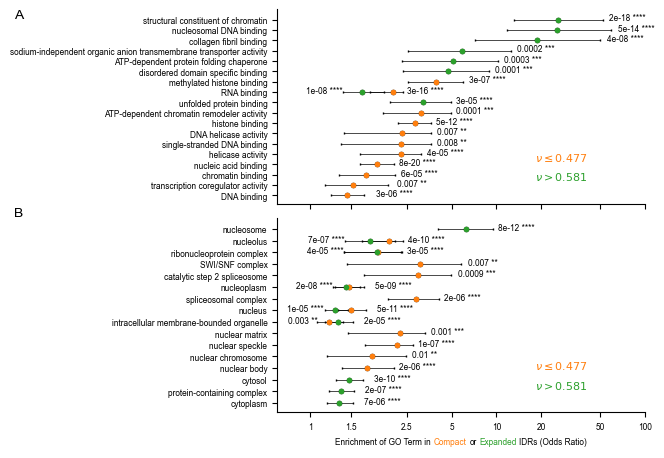

In [80]:
# Load data on enrichment in compact chains
df_nu_stat_compact_func = pd.read_csv('go_analysis/GO_function_analysis_compact.csv',index_col=0)
df_nu_stat_compact_func = df_nu_stat_compact_func.query('correctedP < 0.01 and OR > 1')
df_nu_stat_compact_comp = pd.read_csv('go_analysis/GO_component_analysis_compact.csv',index_col=0)
df_nu_stat_compact_comp = df_nu_stat_compact_comp.query('correctedP < 0.01 and OR > 1')
df_nu_stat_compact_func.asymmetric_err = df_nu_stat_compact_func.asymmetric_err.apply(lambda x : literal_eval(x))
df_nu_stat_compact_comp.asymmetric_err = df_nu_stat_compact_comp.asymmetric_err.apply(lambda x : literal_eval(x))

# Load data on enrichment in expanded chains
df_nu_stat_expanded_func = pd.read_csv('go_analysis/GO_function_analysis_expanded.csv',index_col=0)
df_nu_stat_expanded_func = df_nu_stat_expanded_func.query('correctedP < 0.001 and OR > 1')
df_nu_stat_expanded_comp = pd.read_csv('go_analysis/GO_component_analysis_expanded.csv',index_col=0)
df_nu_stat_expanded_comp = df_nu_stat_expanded_comp.query('correctedP < 0.001 and OR > 1')
df_nu_stat_expanded_func.asymmetric_err = df_nu_stat_expanded_func.asymmetric_err.apply(lambda x : literal_eval(x))
df_nu_stat_expanded_comp.asymmetric_err = df_nu_stat_expanded_comp.asymmetric_err.apply(lambda x : literal_eval(x))

# Combine analyses for compact and expanded chains
df_nu_stat_func = df_nu_stat_compact_func.join(df_nu_stat_expanded_func, lsuffix='_compact', rsuffix='_expanded', how='outer')
df_nu_stat_func['OR'] = (df_nu_stat_func['OR_compact'].fillna(0) + df_nu_stat_func['OR_expanded'].fillna(0))/2
df_nu_stat_func.sort_values('OR',inplace=True)

df_nu_stat_comp = df_nu_stat_compact_comp.join(df_nu_stat_expanded_comp, lsuffix='_compact', rsuffix='_expanded', how='outer')
df_nu_stat_comp['OR'] = (df_nu_stat_comp['OR_compact'].fillna(0) + df_nu_stat_comp['OR_expanded'].fillna(0))/2
df_nu_stat_comp.sort_values('OR',inplace=True)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6.6,4.5))

plt.setp(ax1.get_xticklabels(), visible=False)

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

y = np.arange(df_nu_stat_func.shape[0])+1

df_nu_stat_func.asymmetric_err_compact = df_nu_stat_func.asymmetric_err_compact.apply(
    lambda x : [np.nan,np.nan] if type(x)==float else x)
asymmetric_error_compact = np.array(list(df_nu_stat_func.asymmetric_err_compact)).T

ax1.errorbar(df_nu_stat_func.OR_compact,y,xerr=asymmetric_error_compact, fmt='.', ecolor = 'black',
             elinewidth = 0.5,capsize = 1, color='k')

df_nu_stat_func.asymmetric_err_expanded = df_nu_stat_func.asymmetric_err_expanded.apply(
    lambda x : [np.nan,np.nan] if type(x)==float else x)
asymmetric_error_expanded = np.array(list(df_nu_stat_func.asymmetric_err_expanded)).T

ax1.errorbar(df_nu_stat_func.OR_expanded,y,xerr=asymmetric_error_expanded, fmt='.', ecolor = 'black',
             elinewidth = 0.5,capsize = 1, color='k')
    
ax1.set_xscale('symlog')
ax1.set_xticks([0,.5,1,1.5,2.5,5,10,20,50,100])
ax1.set_xticklabels([f'{i:g}' for i in [0,.5,1,1.5,2.5,5,10,20,50,100]])
ax1.set_yticks(y, df_nu_stat_func.index, rotation=0)
ax1.set_ylim(0.2,df_nu_stat_func.shape[0]+1)
ax1.set_xlim(.6,100)

print('Molecular Function')

labels = df_nu_stat_compact_func.index.values
for func in labels:
    y_text = df_nu_stat_func.index.get_loc(func)+.9
    x_text = df_nu_stat_func.OR_compact[func]+df_nu_stat_func.asymmetric_err_compact[func][1]*1.2+.1
    print('Compact',func,round(df_nu_stat_func.OR_compact[func],1))
    correctedP = df_nu_stat_func.correctedP_compact[func]
    ax1.text(x=x_text, y=y_text, 
             s=f'{correctedP:.1g} '+convert_pvalue_to_asterisks(correctedP),fontsize=6)
for func in labels:
    ax1.plot(df_nu_stat_func.loc[func].OR_compact,
         df_nu_stat_func.index.get_loc(func)+1, marker='o', ms=3, 
             color=plt.cm.tab10(1),zorder=10)
    
labels = df_nu_stat_expanded_func.index.values
for func in labels:
    y_text = df_nu_stat_func.index.get_loc(func)+.9
    x_text = df_nu_stat_func.OR_expanded[func]+df_nu_stat_func.asymmetric_err_expanded[func][1]*1.2
    print('Expanded',func,round(df_nu_stat_func.OR_expanded[func],1))
    if func in ['RNA binding']:
        x_text = df_nu_stat_func.OR_expanded[func]-df_nu_stat_func.asymmetric_err_expanded[func][0]-.45
    correctedP = df_nu_stat_func.correctedP_expanded[func]
    ax1.text(x=x_text, y=y_text, 
             s=f'{correctedP:.1g} '+convert_pvalue_to_asterisks(correctedP),fontsize=6)
for func in labels:
    ax1.plot(df_nu_stat_func.loc[func].OR_expanded,
         df_nu_stat_func.index.get_loc(func)+1, marker='o', ms=3, 
             color=plt.cm.tab10(2),zorder=10)
    
########################

y = np.arange(df_nu_stat_comp.shape[0])+1

df_nu_stat_comp.asymmetric_err_compact = df_nu_stat_comp.asymmetric_err_compact.apply(
    lambda x : [np.nan,np.nan] if type(x)==float else x)
asymmetric_error_compact = np.array(list(df_nu_stat_comp.asymmetric_err_compact)).T

ax2.errorbar(df_nu_stat_comp.OR_compact,y,xerr=asymmetric_error_compact, fmt='.', ecolor = 'black',
             elinewidth = 0.5,capsize = 1, color='k',label='$\\nu\leq0.477$')

df_nu_stat_comp.asymmetric_err_expanded = df_nu_stat_comp.asymmetric_err_expanded.apply(
    lambda x : [np.nan,np.nan] if type(x)==float else x)
asymmetric_error_expanded = np.array(list(df_nu_stat_comp.asymmetric_err_expanded)).T

ax2.errorbar(df_nu_stat_comp.OR_expanded,y,xerr=asymmetric_error_expanded, fmt='.', ecolor = 'black',
             elinewidth = 0.5,capsize = 1, color='k',label='$\\nu>0.581$')

ax2.set_xscale('symlog')
ax2.set_xticks([0,.5,1,1.5,2.5,5,10,20,50,100])
ax2.set_xticklabels([f'{i:g}' for i in [0,.5,1,1.5,2.5,5,10,20,50,100]])
ax2.set_yticks(y, [name.replace('speck','speckle') for name in df_nu_stat_comp.index], rotation=0)
ax2.set_ylim(0.2,df_nu_stat_comp.shape[0]+1)
ax2.set_xlim(.6,100)


xbox1 = TextArea('Enrichment of GO Term in', textprops=dict(color='k',size=6,rotation=0,ha='left',va='bottom'))
xbox2 = TextArea('Compact',     textprops=dict(color='tab:orange', size=6,rotation=0,ha='left',va='bottom'))
xbox3 = TextArea('or', textprops=dict(color='k',size=6,rotation=0,ha='left',va='bottom'))
xbox4 = TextArea('Expanded', textprops=dict(color='tab:green',size=6,rotation=0,ha='left',va='bottom'))
xbox5 = TextArea('IDRs (Odds Ratio)', textprops=dict(color='k',size=6,rotation=0,ha='left',va='bottom'))


xbox = HPacker(children=[xbox1, xbox2, xbox3, xbox4, xbox5],align="bottom", pad=0, sep=2)

anchored_ybox = AnchoredOffsetbox(loc=8, child=xbox, pad=0., frameon=False, bbox_to_anchor=(0.5, -.185), 
                                  bbox_transform=ax2.transAxes, borderpad=0.)

ax2.add_artist(anchored_ybox)
#ax2.set_xlabel(r'Enrichment in Compact or Expanded IDRs (Odds Ratio)')

print('Cell Component')

labels = df_nu_stat_compact_comp.index.values
for comp in labels:
    y_text = df_nu_stat_comp.index.get_loc(comp)+.9
    x_text = df_nu_stat_comp.OR_compact[comp]+df_nu_stat_comp.asymmetric_err_compact[comp][1]*1.2+.1
    print('Compact',comp,round(df_nu_stat_comp.OR_compact[comp],1))
    if comp in ['intracellular membrane-bounded organelle']:
        x_text = df_nu_stat_comp.OR_expanded[comp]-df_nu_stat_comp.asymmetric_err_expanded[comp][0]-.45
    correctedP = df_nu_stat_comp.correctedP_compact[comp]
    ax2.text(x=x_text, y=y_text, 
             s=f'{correctedP:.1g} '+convert_pvalue_to_asterisks(correctedP),fontsize=6)
for comp in labels:
    ax2.plot(df_nu_stat_comp.loc[comp].OR_compact,
         df_nu_stat_comp.index.get_loc(comp)+1, marker='o', ms=3, 
             color=plt.cm.tab10(1),zorder=10)
    
labels = df_nu_stat_expanded_comp.index.values
for comp in labels:
    y_text = df_nu_stat_comp.index.get_loc(comp)+.9
    x_text = df_nu_stat_comp.OR_expanded[comp]+df_nu_stat_comp.asymmetric_err_expanded[comp][1]*1.2+.1
    print('Expanded',comp,round(df_nu_stat_comp.OR_expanded[comp],1))
    if comp in ['nucleolus','nucleoplasm','ribonucleoprotein complex','nucleus']:
        x_text = df_nu_stat_comp.OR_expanded[comp]-df_nu_stat_comp.asymmetric_err_expanded[comp][0]-.45
    correctedP = df_nu_stat_comp.correctedP_expanded[comp]
    ax2.text(x=x_text, y=y_text, 
             s=f'{correctedP:.1g} '+convert_pvalue_to_asterisks(correctedP),fontsize=6)
for comp in labels:
    ax2.plot(df_nu_stat_comp.loc[comp].OR_expanded,
         df_nu_stat_comp.index.get_loc(comp)+1, marker='o', ms=3, 
             color=plt.cm.tab10(2),zorder=10)
    
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.annotate('$\\nu\leq0.477$',xy=(.7,.22),xycoords='axes fraction',
             color='tab:orange',fontsize=8)
ax1.annotate('$\\nu>0.581$',xy=(.7,.12),xycoords='axes fraction',
             color='tab:green',fontsize=8)

ax2.annotate('$\\nu\leq0.477$',xy=(.7,.22),xycoords='axes fraction',
             color='tab:orange',fontsize=8)
ax2.annotate('$\\nu>0.581$',xy=(.7,.12),xycoords='axes fraction',
             color='tab:green',fontsize=8)
    
fig.text(0.02, .96, 'A', fontsize=10)
fig.text(0.02, .52, 'B', fontsize=10)
    
plt.tight_layout()
plt.savefig('figs/fig2.pdf')

#### Generate table with molecular functions

In [105]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)[['nu','UniProt_ID']]

curated_GO_codes = []
for name in df_nu_stat_func.index:
    curated_GO_codes.append(name_to_id[name]) 
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, molfunc) )

for code,func in zip(curated_GO_codes,df_nu_stat_func.index):    
    df_GO[func.replace(' ','_')] = df_GO.UniProt_ID.apply(lambda x : code in GO_terms.loc[x].GO)
    
df_GO.to_csv('go_analysis/IDRome_molfunc.csv')
df_GO.to_excel('go_analysis/IDRome_molfunc.xlsx')  

#### Generate table with cellular component

In [106]:
# Load lists of GO terms for each UniProt ID (see go_analysis/uniprot_API_calls.py)
GO_terms = pd.Series(pd.read_pickle('go_analysis/uniprot_dict.pkl')).to_frame(name='GO')
# Load database
df_GO = pd.read_csv('IDRome_DB.csv',index_col=0)[['nu','UniProt_ID']]

curated_GO_codes = []
for name in df_nu_stat_comp.index:
    curated_GO_codes.append(name_to_id[name]) 
GO_terms.GO = GO_terms.GO.apply( lambda x : map_to_curated_codes(graph, x, curated_GO_codes, cellcom) )

for code,func in zip(curated_GO_codes,df_nu_stat_comp.index):    
    df_GO[func.replace(' ','_')] = df_GO.UniProt_ID.apply(lambda x : code in GO_terms.loc[x].GO)
    
df_GO.to_csv('go_analysis/IDRome_cellcom.csv')
df_GO.to_excel('go_analysis/IDRome_cellcom.xlsx')  